In [ ]:
# IMPORTAÇÃO DE BLIBLIOTECAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown



In [ ]:
# ID do arquivo
file_id = "1PS7IXRzrJOmdUA8YOVmstSah7-25rvNJ"

# Gera o link de download
url = f"https://drive.google.com/uc?id={file_id}"

# Nome do arquivo local
output = "df_enem_tratado.csv"

# Faz o download
gdown.download(url, output, quiet=False)

# Lê o CSV com pandas
df = pd.read_csv(output)

In [4]:

colunas = [
    'NU_ANO', 'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
    'NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT',
    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
    'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'
]

df = df[colunas]
df.dropna(subset=['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO'], how='all', inplace=True)

# Mapeamento do tipo de escola
df['TP_DEPENDENCIA_ADM_ESC'] = df['TP_DEPENDENCIA_ADM_ESC'].map({
    1: 'Não informado', 2: 'Federal', 3: 'Estadual',
    4: 'Municipal', 5: 'Privada', 6: 'Exterior'
})

# Média geral
df['MEDIA_GERAL_2024'] = df[['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']].mean(axis=1)

# ADICIONAR COLUNA REGIÃO
regioes_info = {
    'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['SP', 'RJ', 'MG', 'ES'],
    'Sul': ['PR', 'SC', 'RS']
}
mapa_regioes = {estado: regiao for regiao, estados in regioes_info.items() for estado in estados}
df['REGIAO'] = df['SG_UF_ESC'].map(mapa_regioes)

df.to_csv('df_enem_tratado.csv', index=False)


In [36]:
colunas_para_converter = [
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',
    'MEDIA_GERAL_2024' 
]

df_enem_tratado = df.copy()

for col in colunas_para_converter:
    df_enem_tratado[col] = df_enem_tratado[col].apply(
        lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else ''
    )

sigla_para_nome_estado = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas',
    'BA': 'Bahia', 'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo',
    'GO': 'Goiás', 'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais', 'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná',
    'PE': 'Pernambuco', 'PI': 'Piauí', 'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul', 'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina',
    'SP': 'São Paulo', 'SE': 'Sergipe', 'TO': 'Tocantins'
}

df_enem_tratado['LOCAL_ESTADO'] = df_enem_tratado['SG_UF_ESC'].map(sigla_para_nome_estado) + ', Brazil'


df_enem_tratado['MUN_ESTADO_PAIS'] = df_enem_tratado['NO_MUNICIPIO_ESC'] + ', ' + df_enem_tratado['SG_UF_ESC'] + ', Brazil'



df_enem_tratado.to_csv('df_enem_tratado.csv', index=False)

In [13]:
# --- FUNÇÕES ---
def calcular_estatisticas(array):
    q1, q2, q3 = np.percentile(array, [25, 50, 75])
    media = np.mean(array)
    mediana = np.median(array)
    distancia = (media - mediana) / mediana
    iqr = q3 - q1
    limite_inf, limite_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = (array < limite_inf) | (array > limite_sup)
    return {
        'Q1': q1, 'Q2': q2, 'Q3': q3, 'Média': media, 'Mediana': mediana,
        'Distância %': f"{(distancia * 100):.2f}%", 'Outliers': outliers.sum()
    }

estatisticas_nacionais = calcular_estatisticas(df['MEDIA_GERAL_2024'].dropna())
q1 = estatisticas_nacionais['Q1']
q2 = estatisticas_nacionais['Q2']
q3 = estatisticas_nacionais['Q3']


def exibir_estatisticas(nome, array):
    stats = calcular_estatisticas(array)
    print(f"\nEstatísticas - {nome}:")
    for k, v in stats.items():
        if k == 'Distância %':
            print(f"{k}: {v}")
        else:
            print(f"{k}: {v:.2f}")

def filtrar_regiao(df, estados, nome_media):
    regiao = df[df['SG_UF_ESC'].isin(estados)].copy()
    regiao[nome_media] = regiao[['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']].mean(axis=1)
    return regiao

def plotar_boxplot(data, titulo):
    plt.figure(figsize=(8, 5))
    plt.boxplot(data, vert=True, patch_artist=True)
    plt.title(titulo)
    plt.ylabel('Média Geral')
    plt.show()

def comparar_medias_medianas(medias, medianas, labels):
    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, medias, width=width, label='Média', color='skyblue')
    plt.bar(x + width/2, medianas, width=width, label='Mediana', color='orange')
    plt.xticks(x, labels)
    plt.ylabel('Valores')
    plt.title('Comparação de Média e Mediana por Região')
    plt.legend()
    plt.show()

📊 Estatísticas Nacionais:

Estatísticas - Brasil:
Q1: 472.78
Q2: 531.86
Q3: 599.40
Média: 535.04
Mediana: 531.86
Distância %: 0.60%
Outliers: 21347.00


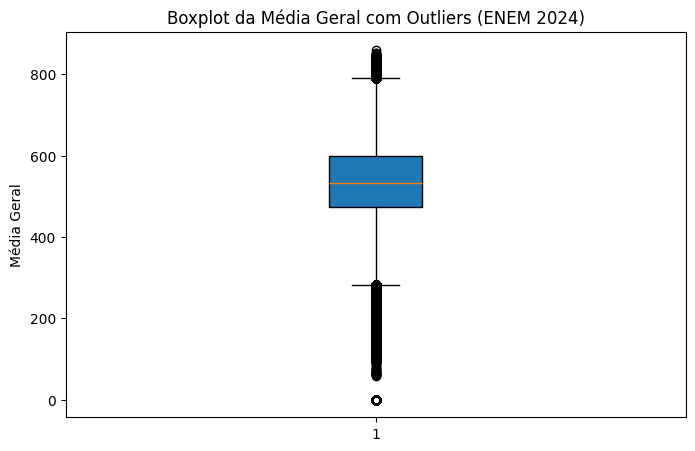

In [7]:
# --- ESTATÍSTICAS NACIONAIS ---
print("📊 Estatísticas Nacionais:")
exibir_estatisticas("Brasil", df['MEDIA_GERAL_2024'])
plotar_boxplot(df['MEDIA_GERAL_2024'], 'Boxplot da Média Geral com Outliers (ENEM 2024)')

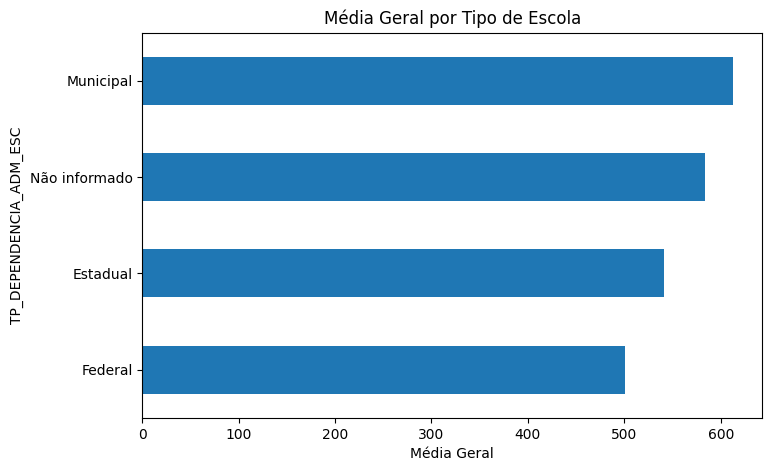

In [25]:
media_por_tipo = df.groupby('TP_DEPENDENCIA_ADM_ESC')['MEDIA_GERAL_2024'].mean().sort_values()
media_por_tipo.plot(kind='barh', figsize=(8, 5), title='Média Geral por Tipo de Escola')
plt.xlabel('Média Geral')
plt.show()


ESTATÍSTICAS POR REGIÃO

In [8]:
medias_regioes = []
medianas_regioes = []
nomes_regioes = []

for regiao in df['REGIAO'].dropna().unique():   # Garantir que não haja NaN
    df_regiao = df[df['REGIAO'] == regiao]
    array_media = df_regiao['MEDIA_GERAL_2024'].dropna()

    if len(array_media) > 0:  # Só calcula estatísticas se houver dados
        exibir_estatisticas(regiao, array_media)
        medias_regioes.append(np.mean(array_media))
        medianas_regioes.append(np.median(array_media))
        nomes_regioes.append(regiao)
    else:
        print(f"Atenção: Região '{regiao}' não possui dados suficientes para análise!")



Estatísticas - Nordeste:
Q1: 444.30
Q2: 504.46
Q3: 573.26
Média: 507.43
Mediana: 504.46
Distância %: 0.59%
Outliers: 2402.00

Estatísticas - Sul:
Q1: 487.66
Q2: 542.40
Q3: 603.52
Média: 544.13
Mediana: 542.40
Distância %: 0.32%
Outliers: 1719.00

Estatísticas - Norte:
Q1: 437.58
Q2: 490.20
Q3: 551.08
Média: 493.97
Mediana: 490.20
Distância %: 0.77%
Outliers: 1895.00

Estatísticas - Sudeste:
Q1: 489.06
Q2: 547.50
Q3: 613.64
Média: 550.22
Mediana: 547.50
Distância %: 0.50%
Outliers: 2361.00

Estatísticas - Centro-Oeste:
Q1: 469.60
Q2: 527.24
Q3: 594.21
Média: 530.68
Mediana: 527.24
Distância %: 0.65%
Outliers: 907.00


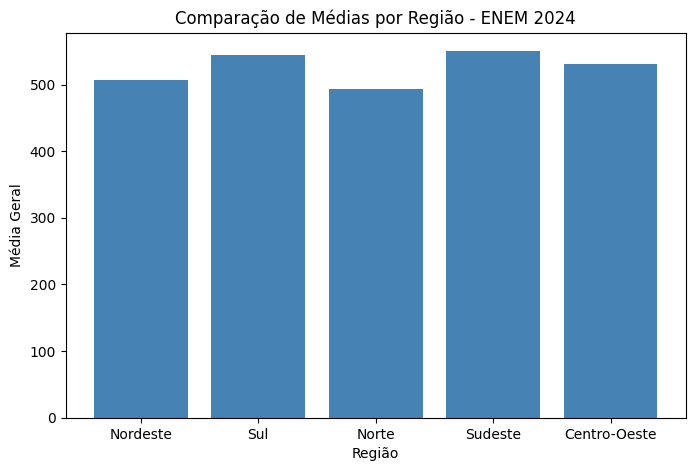

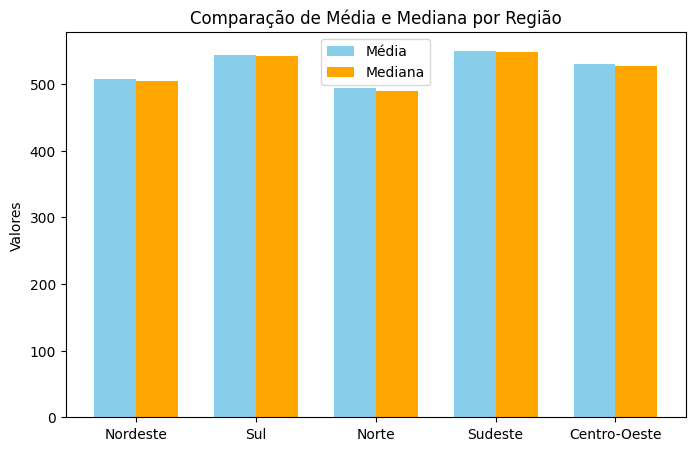

In [26]:
# COMPARAÇÕES GRÁFICAS
plt.figure(figsize=(8, 5))
plt.bar(nomes_regioes, medias_regioes, color='steelblue')
plt.title('Comparação de Médias por Região - ENEM 2024')
plt.ylabel('Média Geral')
plt.xlabel('Região')
plt.show()

comparar_medias_medianas(medias_regioes, medianas_regioes, nomes_regioes)

Estatísticas por Estados

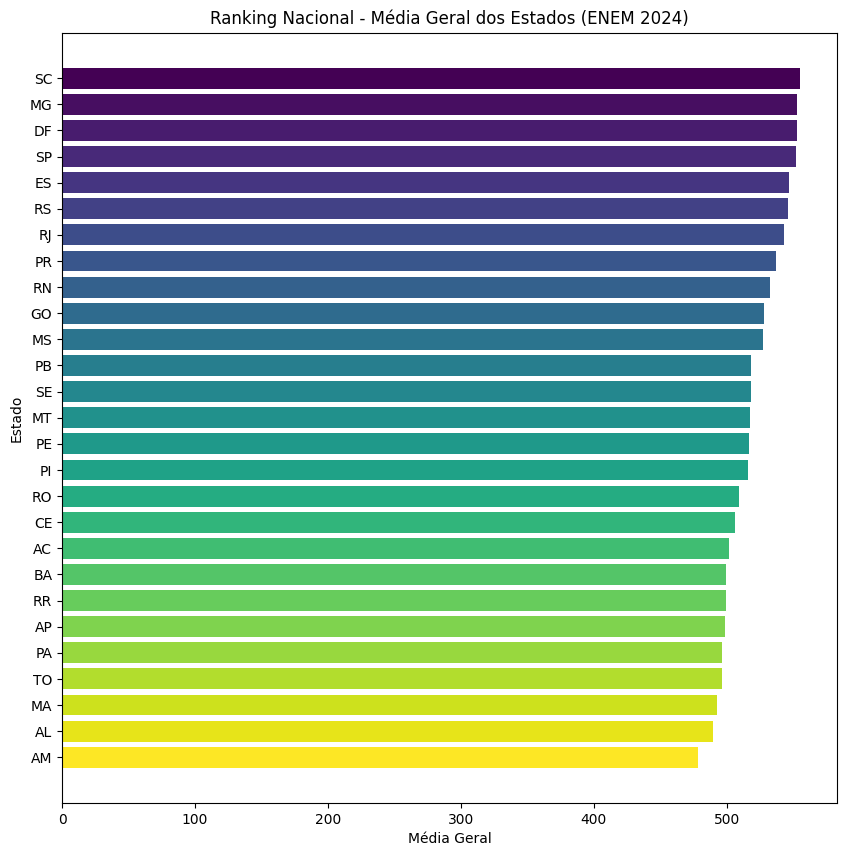


🔝 Estado com maior média: SC (555.15)
🔻 Estado com menor média: AM (478.37)


In [10]:
ranking_estados = df.groupby('SG_UF_ESC')['MEDIA_GERAL_2024'].mean().sort_values(ascending=False)
ranking_df = ranking_estados.reset_index()

plt.figure(figsize=(10,10))
plt.barh(ranking_df['SG_UF_ESC'], ranking_df['MEDIA_GERAL_2024'], color=plt.cm.viridis(np.linspace(0, 1, len(ranking_df))))
plt.title("Ranking Nacional - Média Geral dos Estados (ENEM 2024)")
plt.xlabel("Média Geral")
plt.ylabel("Estado")
plt.gca().invert_yaxis()
plt.show()

print(f"\n🔝 Estado com maior média: {ranking_estados.index[0]} ({ranking_estados.iloc[0]:.2f})")
print(f"🔻 Estado com menor média: {ranking_estados.index[-1]} ({ranking_estados.iloc[-1]:.2f})")

In [14]:
# ESTADOS COM OUTILIERS PARA CIMA
quarto_quartil = ranking_df[ranking_df['MEDIA_GERAL_2024'] >= q3]
quarto_quartil = quarto_quartil.sort_values(by= 'MEDIA_GERAL_2024', ascending= False)
quarto_quartil


,SG_UF_ESC,MEDIA_GERAL_2024


In [ ]:
# ESTADOS COM OUTILIERS PARA BAIXO
primeiro_quartil = ranking_df[ranking_df['MEDIA_GERAL_2024'] <= q1]
primeiro_quartil = primeiro_quartil.sort_values(by= 'MEDIA_GERAL_2024', ascending= False)
primeiro_quartil


,SG_UF_ESC,MEDIA_GERAL_2024


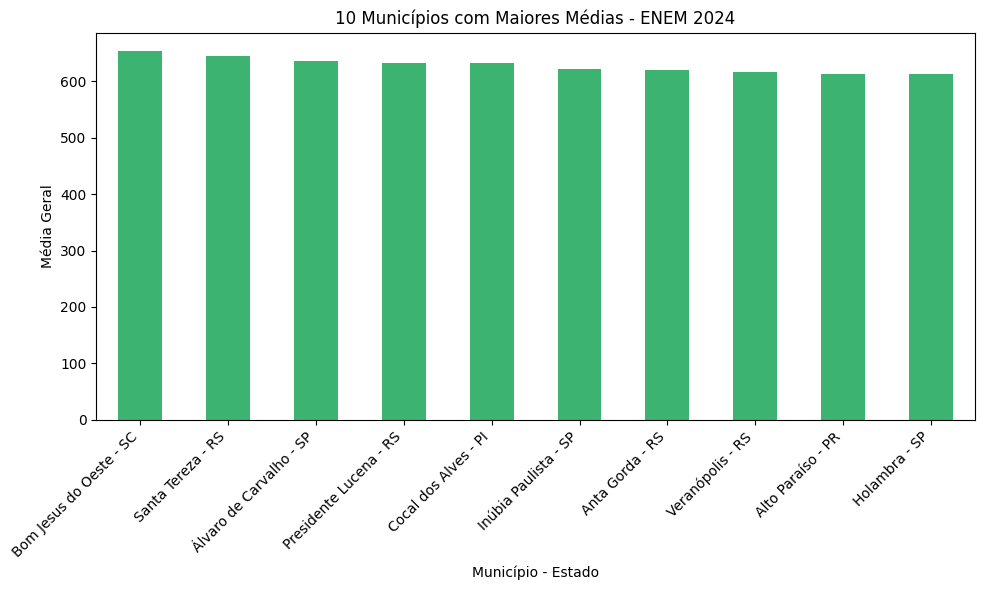

In [29]:
# Agrupar por Município + Estado
df['MUNICIPIO_ESTADO'] = df['NO_MUNICIPIO_ESC'] + ' - ' + df['SG_UF_ESC']
municipios_maiores = df.groupby('MUNICIPIO_ESTADO')['MEDIA_GERAL_2024'].mean().sort_values(ascending=False).head(10)

# Plotar gráfico
plt.figure(figsize=(10, 6))
municipios_maiores.plot(kind='bar', color='mediumseagreen')
plt.title('10 Municípios com Maiores Médias - ENEM 2024')
plt.ylabel('Média Geral')
plt.xlabel('Município - Estado')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


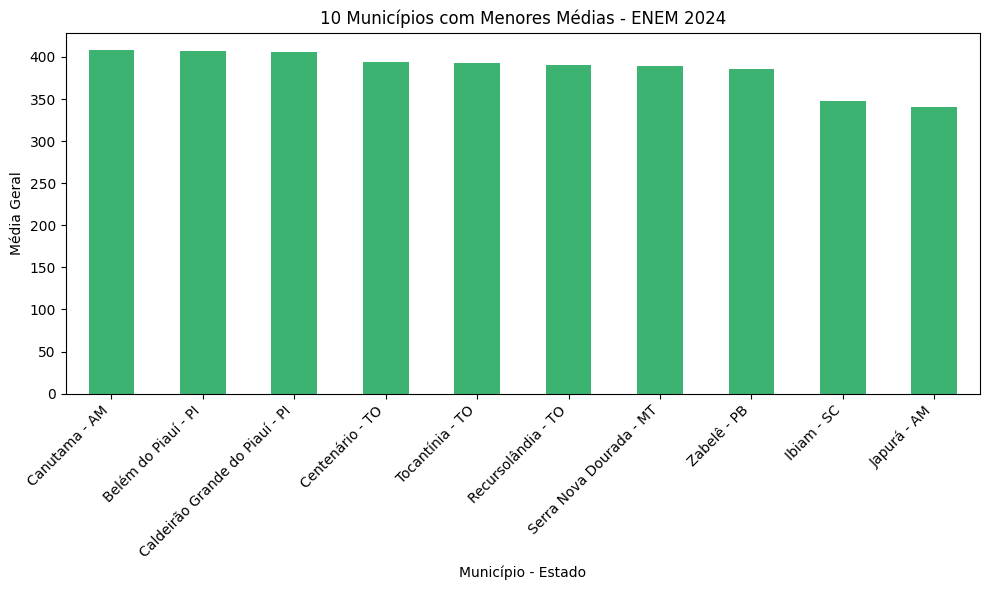

In [30]:
municipios_menores = df.groupby('MUNICIPIO_ESTADO')['MEDIA_GERAL_2024'].mean().sort_values(ascending=False).tail(10)

# Plotar gráfico
plt.figure(figsize=(10, 6))
municipios_menores.plot(kind='bar', color='mediumseagreen')
plt.title('10 Municípios com Menores Médias - ENEM 2024')
plt.ylabel('Média Geral')
plt.xlabel('Município - Estado')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
